# Lista 3

### Zadanie 1



In [ ]:
import numpy as np

# float 32 - pojedyncza precyzja

def hilbert_matrix(n, dtype=np.float32):
    """Buduje macierz Hilberta nxn."""
    H = np.empty((n, n), dtype=dtype)
    for i in range(n):
        for j in range(n):
            H[i, j] = 1.0 / (i + j + 1) # indeksy i oraz j zaczynają się od 0 stąd tak
    return H


def lu_decomposition(A):
    """
    Rozkład LU macierzy A metodą Doolittle'a:
    A = L * U, L - z jedynkami na diagonali.
    Cel: znaleźć macierze L (dolnotrójkątną z jedynkami na przekątnej) i U (górnotrójkątną), takie że A=LU.
    """
    A = A.astype(np.float32)
    n = A.shape[0]

    L = np.eye(n, dtype=np.float32)
    U = np.zeros((n, n), dtype=np.float32)

    for k in range(n):
        # Wiersz k macierzy U
        for j in range(k, n):
            s = np.dot(L[k, :k], U[:k, j])
            U[k, j] = A[k, j] - s

        # Kolumna k macierzy L (poniżej diagonali)
        for i in range(k + 1, n):
            s = np.dot(L[i, :k], U[:k, k])
            L[i, k] = (A[i, k] - s) / U[k, k]

    return L, U 


def forward_substitution(L, b):
    """Rozwiązuje układ L z = b (L - dolnotrójkątna, diag(L)=1). Przechodzę od góry do dołu"""
    n = L.shape[0]
    z = np.zeros(n, dtype=np.float32)
    for i in range(n):
        s = np.dot(L[i, :i], z[:i])
        z[i] = b[i] - s
    return z


def backward_substitution(U, z):
    """Rozwiązuje układ U x = z (U – górnotrójkątna). Przechodzę od dołu do góry"""
    n = U.shape[0]
    x = np.zeros(n, dtype=np.float32)
    for i in range(n - 1, -1, -1):
        s = np.dot(U[i, i + 1:], x[i + 1:])
        x[i] = (z[i] - s) / U[i, i]
    return x


def solve_lu(L, U, b):
    """Rozwiązuje A x = b, mając rozkład A = L U."""
    z = forward_substitution(L, b.astype(np.float32))
    x = backward_substitution(U, z)
    return x

#  Iteracyjne poprawianie

def solve_with_refinement(A_single, b_single, max_iter=50):
    """
    Rozwiązuje A x = b w pojedynczej precyzji z iteracyjnym poprawianiem.
    - rozkład LU i rozwiązywanie: float32
    - residuum liczone w float64 (dokładniej).
    """
    # Rozkład LU w pojedynczej precyzji
    L, U = lu_decomposition(A_single)

    # Pierwsze przybliżenie (float32)
    x = solve_lu(L, U, b_single)

    # Epsilon maszynowy dla float32
    eps32 = np.finfo(np.float32).eps

    for it in range(max_iter):
        # Liczymy residuum w podwójnej precyzji (dokładniej)
        A64 = A_single.astype(np.float64)
        b64 = b_single.astype(np.float64)
        x64 = x.astype(np.float64)

        r64 = b64 - A64 @ x64  # r = b - A x

        # Kryterium zakończenia
        if np.linalg.norm(r64, np.inf) <= max(
            np.linalg.norm(A64 @ x64, np.inf) * eps32,
            np.linalg.norm(b64, np.inf) * eps32
        ):
            # Zbieżność
            break

        # Korekta w float32: A * delta = r
        r32 = r64.astype(np.float32)
        delta32 = solve_lu(L, U, r32)

        # Aktualizacja rozwiązania w float32
        x = (x + delta32).astype(np.float32)

    return x


if __name__ == "__main__":
    # Macierz Hilberta 5x5 i wektor prawej strony
    A = hilbert_matrix(5, dtype=np.float32)
    b = np.array([5, 4, 3, 2, 1], dtype=np.float32)

    x_refined = solve_with_refinement(A, b)
    print("Rozwiązanie z iteracyjnym poprawianiem (float32):")
    print(x_refined)

    # Dla porównania: bez poprawiania, w float32
    x_direct = np.linalg.solve(A, b)
    print("\nRozwiązanie bez poprawiania (np.linalg.solve, float32):")
    print(x_direct)


Rozwiązanie z iteracyjnym poprawianiem (float32):
[   -94.84782   2157.1013  -10697.322    17900.658    -9440.465  ]

Rozwiązanie bez poprawiania (np.linalg.solve, float32):
[   -94.84782   2157.1013  -10697.322    17900.658    -9440.465  ]


### Zadanie 2

In [1]:
import numpy as np

def gauss_seidel(A, b, tol=1e-10, max_iter=10000):
    n = len(b)
    x = np.zeros(n)

    for it in range(max_iter):
        x_new = np.copy(x)
        
        for i in range(n):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i+1:], x[i+1:])
            x_new[i] = (b[i] - s1 - s2) / A[i, i]

        if np.linalg.norm(x_new - x, ord=np.inf) < tol:
            return x_new, it+1

        x = x_new

    return x, max_iter


In [5]:
def build_matrix(n):
    A = np.zeros((n, n))
    
    for i in range(n):
        A[i, i] = 4
        if i > 0:
            A[i, i-1] = -1
        if i < n-1:
            A[i, i+1] = -1

    # sprzężenie pierwszego i ostatniego wiersza
    A[0, n-1] = 1
    A[n-1, 0] = 1
    return A

def build_rhs(n):
    b = np.zeros(n)
    b[-1] = 100
    return b


In [ ]:
n = 20
A = build_matrix(n)
b = build_rhs(n)

x, iters = gauss_seidel(A, b)

print("Liczba iteracji:", iters)
print("Rozwiązanie:")
print(x)

Liczba iteracji: 24
Rozwiązanie:
[-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834754e-02 -2.86164519e-03 -7.63105390e-04
 -1.90776352e-04 -4.32077955e-12  1.90776342e-04  7.63105379e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]


In [12]:
import matplotlib.pyplot as plt
from scipy.linalg import solve
x_direct = solve(A, b)
print("Rozwiązanie scipy.linalg.solve:\n", x_direct)

Rozwiązanie scipy.linalg.solve:
 [-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04 -3.63138871e-20  1.90776345e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]


### Zadanie 3

Liczenie dla n = 10 ...
Liczenie dla n = 20 ...
Liczenie dla n = 50 ...
Liczenie dla n = 100 ...
Liczenie dla n = 500 ...
Liczenie dla n = 1000 ...
Liczenie dla n = 5000 ...
Liczenie dla n = 10000 ...

Rozmiar n | Czas Gauss–Seidel (s) | Czas metody dokładnej (s) | Iteracje GS
      10 |               0.006475 |                  0.005948 |          19
      20 |               0.000727 |                  0.000698 |          20
      50 |               0.001513 |                  0.000052 |          20
     100 |               0.002938 |                  0.002285 |          20
     500 |               0.032675 |                  0.010142 |          20
    1000 |               0.059720 |                  0.115763 |          20
    5000 |               0.455793 |                  1.368931 |          20
   10000 |               1.132605 |                  6.443634 |          20


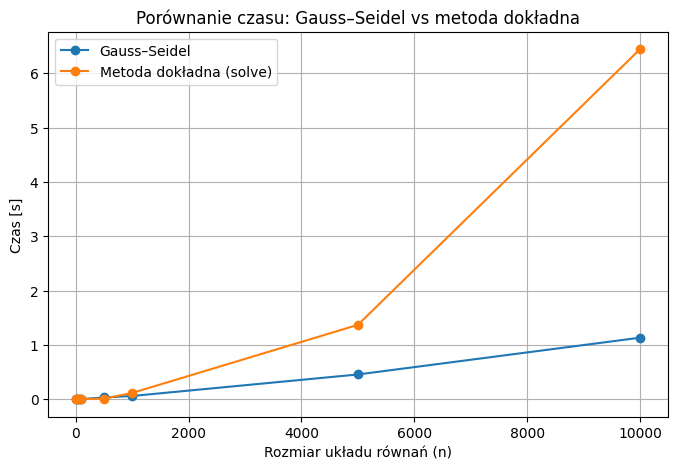

In [ ]:
import time
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# porównanie metody Gaussa–Seidla z metodą dokładną 

# n_values – rozmiary układów, które badamy:
# - zaczynamy od bardzo małych (10, 20), żeby zobaczyć, że obie metody są bardzo szybkie
# - potem zwiększamy n (50, 100, 500, 1000), żeby zobaczyć, jak rośnie czas obliczeń
# - na końcu duże n (5000, 10000), żeby było widać różnicę złożoności obliczeniowej
#   i kiedy metoda dokładna zaczyna być wyraźnie wolniejsza
n_values = [10, 20, 50, 100, 500, 1000, 5000, 10000]

results = []  # tu będziemy zbierać wyniki do tabeli

for n in n_values:
    print(f"Liczenie dla n = {n} ...")
    
    # budujemy macierz A i wektor b z zadania 2
    A = build_matrix(n)
    b = build_rhs(n)

    # --- 1) Metoda Gaussa–Seidla (iteracyjna) ---
    t0 = time.perf_counter()
    x_gs, iters = gauss_seidel(A, b, tol=1e-8, max_iter=100000)
    t1 = time.perf_counter()
    time_gs = t1 - t0

    # --- 2) Metoda dokładna (scipy.linalg.solve) ---
    t2 = time.perf_counter()
    x_direct = solve(A, b)
    t3 = time.perf_counter()
    time_direct = t3 - t2

    # zapisujemy: rozmiar, czas GS, czas solve, liczbę iteracji GS
    results.append([n, time_gs, time_direct, iters])

# wypisujemy tabelę w prostym formacie
print("\nRozmiar n | Czas Gauss–Seidel (s) | Czas metody dokładnej (s) | Iteracje GS")
for row in results:
    print(f"{row[0]:8d} | {row[1]:22.6f} | {row[2]:25.6f} | {row[3]:11d}")

# --- wykres porównujący czasy ---

ns = [r[0] for r in results]
times_gs = [r[1] for r in results]
times_direct = [r[2] for r in results]

plt.figure(figsize=(8,5))
plt.plot(ns, times_gs, marker='o', label="Gauss–Seidel")
plt.plot(ns, times_direct, marker='o', label="Metoda dokładna (solve)")
plt.xlabel("Rozmiar układu równań (n)")
plt.ylabel("Czas [s]")
plt.title("Porównanie czasu: Gauss–Seidel vs metoda dokładna")
plt.grid(True)
plt.legend()
plt.show()




### Wniosek

**Metoda Gaussa–Seidela:**  
Jest to metoda iteracyjna, której złożoność obliczeniowa zależy od liczby wykonanych iteracji.  
Dla rzadkiej macierzy z zadania jedna iteracja wymaga około \(O(n)\) operacji,  
co daje łączny nakład obliczeń rzędu \(O(k n)\).  
Czas działania rośnie umiarkowanie wraz ze wzrostem rozmiaru układu.

**Metoda dokładna (solve):**  
Wykorzystuje rozkład LU o złożoności \(O(n^3)\).  
Dla małych układów działa bardzo szybko, lecz wraz ze wzrostem \(n\)  
czas obliczeń rośnie znacznie szybciej niż w metodzie iteracyjnej.

**Podsumowanie:**  
Dla małych układów metoda dokładna zapewnia najszybsze działanie,  
natomiast dla dużych i rzadkich macierzy bardziej wydajna staje się metoda Gaussa–Seidela,  
ponieważ jej zapotrzebowanie na obliczenia rośnie dużo wolniej.


### Zadanie 4

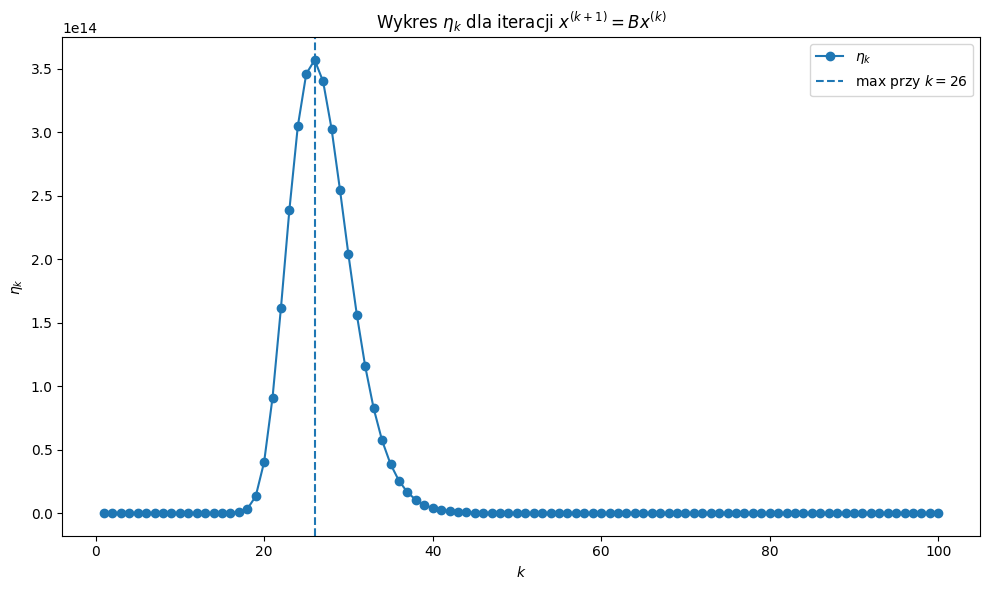

Maksimum η_k osiągane dla k = 26, η_max = 3.571e+14
Najmniejsze k z ||x^(k)||_2 < ||x^(0)||_2 to k = 86


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def build_upper_bidiagonal(n):
    """
    Tworzy górną macierz dwudiagonalną B ∈ R^{nxn}:
    diag(B)   = 0.025, 0.05, ..., 0.025*n
    superdiag = 5
    """
    B = np.zeros((n, n), dtype=float)
    # główna przekątna
    for i in range(n):
        B[i, i] = 0.025 * (i + 1)
        if i < n - 1:
            B[i, i + 1] = 5.0
    return B

def compute_etas(B, x0, max_iter=100):
    """
    Zwraca listę eta_k = ||x^(k)||_2 / ||x^(0)||_2 dla k = 1..max_iter,
    gdzie x^(k+1) = B x^(k), x^(0) = x0.
    """
    x = x0.copy()
    base_norm = np.linalg.norm(x0, 2)
    etas = []

    for k in range(1, max_iter + 1):
        # iteracja: x^{(k)} = B x^{(k-1)}
        x = B @ x
        eta_k = np.linalg.norm(x, 2) / base_norm # jak bardzo urosła norma względem normy początkowej
        etas.append(eta_k)

    return etas

def main():
    n = 20
    B = build_upper_bidiagonal(n)
    x0 = np.ones(n)

    etas = compute_etas(B, x0, max_iter=100)

    ks = np.arange(1, len(etas) + 1) # będzie jak oś x na wykresie

    # wykres η_k
    plt.figure(figsize=(10, 6))
    plt.plot(ks, etas, marker='o', label=r'$\eta_k$')
    plt.title(r'Wykres $\eta_k$ dla iteracji $x^{(k+1)} = B x^{(k)}$')
    plt.xlabel(r'$k$')
    plt.ylabel(r'$\eta_k$')

    # indeks maksimum
    k_max = int(np.argmax(etas) + 1) # zwraca indeks pierwszego największego elementu w etas
    plt.axvline(k_max, linestyle='--', label=fr'max przy $k = {k_max}$') # wizualna reprezentacja gdzie etas osiąga największą wartość

    plt.legend()
    plt.tight_layout()
    plt.show()

    # wypisanie informacji z treści zadania
    print(f"Maksimum η_k osiągane dla k = {k_max}, η_max = {etas[k_max-1]:.3e}")

    # sprawdzenie, od którego k η_k < 1 (czyli ||x^(k)||_2 < ||x^(0)||_2)
    k_min_less_than_1 = None
    for idx, eta_val in enumerate(etas, start=1):  # idx = rzeczywiste k
        if eta_val < 1.0: # sprawdza czy norma wektora w k-tej iteracji jest mniejsza niż norma wektora początkowego.
            k_min_less_than_1 = idx
            break

    if k_min_less_than_1 is not None:
        print(f"Najmniejsze k z ||x^(k)||_2 < ||x^(0)||_2 to k = {k_min_less_than_1}")
    else:
        print("Dla k = 1..100 nie znaleziono η_k < 1.")

if __name__ == "__main__":
    main()

